### Creating Custom Datasets and Finetuning Pre-trained Networks
In this notebook you have to create custom datasets for PyTorch and use this dataset to finetune certain pre-trained neural networks and observe the results.

In [1]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import sys
sys.path.append('/home/tulsyan/apps/miniconda2/lib/python2.7/site-packages/')
sys.path.append('/home/tulsyan/apps/miniconda2/lib/python2.7/site-packages/torchvision-0.1.9-py2.7.egg')
# print(sys.path)

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision import datasets

%matplotlib inline
import matplotlib.pyplot as plt

All hyper parameters go in the next block

In [12]:
use_gpu = True and torch.cuda.is_available()
    
num_classes = 10
batch_size = 50
num_epochs = 5
learning_rate = 0.5
#20,0.5:79%
#

### Creating Custom Datasets
Your first task is to create a pipeline for the custom dataset so that you can load it using a dataloader. Download the dataset provided in the assignment webpage and complete the following block of code so that you can load it as if it was a standard dataset.

In [3]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # root_dir  - the root directory of the dataset
        # train     - a boolean parameter representing whether to return the training set or the test set
        # transform - the transforms to be applied on the images before returning them
        #
        # In this function store the parameters in instance variables and make a mapping
        # from images to labels and keep it as an instance variable. Make sure to check which
        # dataset is required; train or test; and create the mapping accordingly.
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        if train:
            root_dir += 'train/'
        else:
            root_dir += 'test/'
        self.imagefolder_dataset = datasets.ImageFolder(root=root_dir,
                                                       transform=transform)
        
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        
        return self.imagefolder_dataset.__len__()
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        #
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        image, label = self.imagefolder_dataset.__getitem__(idx)
        return (image, label)

We shall now load the dataset. You just need to supply the `root_dir` in the block below and if you implemented the above block correctly, it should work without any issues.

Size of train dataset: 16854
Size of test dataset: 1870
Train images
Test images


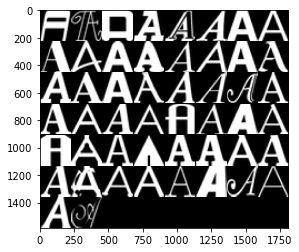

In [13]:
composed_transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='../custom_dataset/', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='../custom_dataset/', train=False, transform=composed_transform) # Supply proper root_dir

# Let's check the size of the datasets, if implemented correctly they should be 16854 and 1870 respectively
print('Size of train dataset: %d' % len(train_dataset))
print('Size of test dataset: %d' % len(test_dataset))

# Create loaders for the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Let's look at one batch of train and test images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

train_dataiter = iter(train_loader)
train_images, train_labels = train_dataiter.next()
# print(type(train_images), train_images.shape)
print("Train images")
imshow(torchvision.utils.make_grid(train_images))

test_dataiter = iter(test_loader)
test_images, test_labels = test_dataiter.next()
print("Test images")
imshow(torchvision.utils.make_grid(test_images))

### VGG-16 and Resnet-18
Now that you have created the dataset we can use it for training and testing neural networks. VGG-16 and Resnet-18 are both well-known deep-net architectures. VGG-16 is named as such since it has 16 layers in total (13 convolution and 3 fully-connected). Resnet-18 on the other hand is a Resnet architecture that uses skip-connections. PyTorch provides pre-trained models of both these architectures and we shall be using them directly. If you are interested in knowing how they have been defined do take a look at the source, [VGG](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py), [Resnet](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [14]:
# vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)

# Code to change the last layers so that they only have 10 classes as output
# vgg16.classifier = nn.Sequential(
#     nn.Linear(512 * 7 * 7, 4096),
#     nn.ReLU(True),
#     nn.Dropout(),
#     nn.Linear(4096, 4096),
#     nn.ReLU(True),
#     nn.Dropout(),
#     nn.Linear(4096, 10),
# )
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

Initialize cuda

In [15]:
# Add code for using CUDA here if it is available
if(torch.cuda.is_available() and use_gpu):
#     vgg16.cuda()
    resnet18.cuda()

Define loss functions and optimizers

In [16]:
criterion = nn.CrossEntropyLoss()
# Define cross-entropy loss
# optimizer_vgg16 = torch.optim.Adam(vgg16.parameters(), lr=learning_rate)
# Use Adam optimizer, use learning_rate hyper parameter
optimizer_resnet18 = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)
# Use Adam optimizer, use learning_rate hyper parameter

#### Finetuning
Finetuning is nothing but training models after their weights have been loaded. This allows us to start at a better position than training from scratch. Since the models created already have weights loaded, you simply need to write a training loop.

In [17]:
# def train_vgg16():
#     # Write loops so as to train the model for N epochs, use num_epochs hyper parameter
#     # Train/finetune the VGG-16 network
#     # Store the losses for every epoch and generate a graph using matplotlib
#     loss_store = []
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for i, (images, labels) in enumerate(train_loader):
#             # Convert torch tensor to Variable
#             images = Variable(images)
#             labels = Variable(labels)
#             if (use_gpu):
#                 images = images.cuda()
#                 labels = labels.cuda()
#             # Forward + Backward + Optimize
#             optimizer_vgg16.zero_grad()  # zero the gradient buffer
#             outputs = vgg16(images)
#             print(outputs.dtype)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer_vgg16.step()    
            
#             running_loss += loss.data[0]
#             print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
#                    %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0])) 
#         loss_store += [running_loss]
#     plt.plot(loss_store)
#     plt.show()
    
def train_resnet18():
    # Same as above except now using the Resnet-18 network

    loss_store = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if (use_gpu):
                images = images.cuda()
                labels = labels.cuda()
            # Forward + Backward + Optimize
            optimizer_resnet18.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_resnet18.step()    
            
            running_loss += loss.data[0]
            
            if (i+1)%10 == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
        loss_store += [running_loss]

    plt.plot(loss_store)
    plt.show()

Now let us start the training/finetuning

Epoch [1/5], Step [10/337], Loss: 4.6635
Epoch [1/5], Step [20/337], Loss: 3.3401
Epoch [1/5], Step [30/337], Loss: 3.1032
Epoch [1/5], Step [40/337], Loss: 2.2847
Epoch [1/5], Step [50/337], Loss: 2.1799
Epoch [1/5], Step [60/337], Loss: 2.2527
Epoch [1/5], Step [70/337], Loss: 1.9288
Epoch [1/5], Step [80/337], Loss: 1.9171
Epoch [1/5], Step [90/337], Loss: 2.0938
Epoch [1/5], Step [100/337], Loss: 2.0859
Epoch [1/5], Step [110/337], Loss: 2.0164
Epoch [1/5], Step [120/337], Loss: 2.0833
Epoch [1/5], Step [130/337], Loss: 1.8557
Epoch [1/5], Step [140/337], Loss: 1.7313
Epoch [1/5], Step [150/337], Loss: 1.3447
Epoch [1/5], Step [160/337], Loss: 1.5038
Epoch [1/5], Step [170/337], Loss: 1.3235
Epoch [1/5], Step [180/337], Loss: 1.1291
Epoch [1/5], Step [190/337], Loss: 1.3262
Epoch [1/5], Step [200/337], Loss: 1.1576
Epoch [1/5], Step [210/337], Loss: 1.0317
Epoch [1/5], Step [220/337], Loss: 0.9693
Epoch [1/5], Step [230/337], Loss: 0.8156
Epoch [1/5], Step [240/337], Loss: 0.7145
E

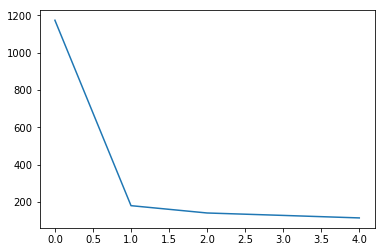

CPU times: user 1h 4min 58s, sys: 15min 9s, total: 1h 20min 7s
Wall time: 1h 12min 47s


In [18]:
# %time train_vgg16()
%time train_resnet18()

In [ ]:
torch.save(resnet18.state_dict(), 'resnet18_model.pkl')

#### Testing
Once finetuning is done we need to test it on the test set.

In [10]:
def test(model):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images)
        
        if (use_gpu):
            images = images.cuda()
            
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

Test the models

In [11]:
# %time test(vgg16)
# resnet18.load_state_dict(torch.load('resnet18_model.pkl'))
%time test(resnet18)

Accuracy of the network on the 1870 test images: 79 %
CPU times: user 46.8 s, sys: 6.59 s, total: 53.4 s
Wall time: 32.5 s


You can add more code to save the models if you want but otherwise this notebook is complete